# 1. Preparing Data for Consumption

In [3]:
import sys

import pandas as pd
import matplotlib
import numpy as np
import scipy as sp

import IPython
from IPython import display

import sklearn

import random
import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [5]:
data_raw = pd.read_csv('../data/train.csv')
data_val = pd.read_csv('../data/test.csv')

data1 = data_raw.copy(deep=True)

data_cleaner = [data1, data_val]

data_raw.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
175,176,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,350404,7.8542,NaN,S
521,522,0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S
222,223,0,3,"Green, Mr. George Henry",male,51.0,0,0,21440,8.0500,NaN,S
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",male,51.0,0,0,347064,7.7500,NaN,S
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S
383,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S
790,791,0,3,"Keane, Mr. Andrew ""Andy""",male,NaN,0,0,12460,7.7500,NaN,Q
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S


In [6]:
print(data1.isnull().sum())
print('-' * 20)
print(data_val.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:
### COMPLETING: Imputing

for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
    
drop_columns = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_columns, axis=1, inplace=True)

print(data1.isnull().sum())
print('-' * 20)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [8]:
### CREATING: Feature Engineering

for dataset in data_cleaner:
    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
stat_min = 10

title_names = (data1['Title'].value_counts() < stat_min)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

data1['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [9]:
data1.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,29.1250,Q,6,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
601,0,3,"Slabenoff, Mr. Petco",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
330,1,3,"McCoy, Miss. Agnes",female,28.0,2,0,23.2500,Q,3,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"
663,0,3,"Coleff, Mr. Peju",male,36.0,0,0,7.4958,S,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
163,0,3,"Calic, Mr. Jovo",male,17.0,0,0,8.6625,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
825,0,3,"Flynn, Mr. John",male,28.0,0,0,6.9500,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
870,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
34,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,82.1708,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
588,0,3,"Gilinski, Mr. Eliezer",male,22.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
377,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,211.5000,C,3,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"


In [33]:
### CONVERTING: Label Encoder

label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived'] 

data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] 
# data1_xy =  Target + data1_x
# print('Original X Y: ', data1_xy, '\n')

data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
# data1_xy_bin = Target + data1_x_bin
# print('Bin X Y: ', data1_xy_bin, '\n')

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
# data1_xy_dummy = Target + data1_x_dummy
# print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.sample(10)

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
588,3,0,0,22.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0
691,3,0,1,4.0,13.4167,2,0,1,0,1,0,0,0,0,1,0,0
529,2,2,1,23.0,11.5000,4,0,0,1,0,0,1,0,0,0,1,0
250,3,0,0,28.0,7.2500,1,1,0,1,0,0,1,0,0,0,1,0
269,1,0,0,35.0,135.6333,1,1,1,0,0,0,1,0,0,1,0,0
190,2,0,0,32.0,13.0000,1,1,1,0,0,0,1,0,0,0,0,1
822,1,0,0,38.0,0.0000,1,1,0,1,0,0,1,0,1,0,0,0
349,3,0,0,42.0,8.6625,1,1,0,1,0,0,1,0,0,0,1,0
695,2,0,0,52.0,13.5000,1,1,0,1,0,0,1,0,0,0,1,0
705,2,0,0,39.0,26.0000,1,1,0,1,0,0,1,0,0,0,1,0


In [34]:
print(data1.info())
print('-' * 20)
print(data1.isnull().sum())
print('-' * 20)
print(data_val.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 non-null    object  
 9   FamilySize     891 non-null    int64   
 10  IsAlone        891 non-null    int64   
 11  Title          891 non-null    object  
 12  FareBin        891 non-null    category
 13  AgeBin         891 non-null    category
 14  Sex_Code       891 non-null    int64   
 15  Embarked_Code  891 non-null    int64   
 16  Title_Code     891 non-null    int64   
 17  AgeBin_Code    891 non-null    int6

In [45]:
### TRAIN AND TEST SPLIT

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)

train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state=0)

train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print(f'Data1 Shape: {data1.shape}')
print(f'Train1 Shape: {train1_x.shape}')
print(f'Test1 Shape: {test1_x.shape}')

train1_x.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,SibSp,Parch,Age,Fare
105,1,3,2,3,0,0,28.0,7.8958
68,0,3,2,2,4,2,17.0,7.9250
253,1,3,2,3,1,0,30.0,16.1000
320,1,3,2,3,0,0,22.0,7.2500
706,0,2,2,4,0,0,45.0,13.5000


# 2. Performing Exploratory Data Analysis

In [44]:
### CHECKING CORRELATION

for x in data1_x:
    if data1[x].dtype != 'float64':
        print(f'Survival Correlation by {x}')
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-' * 20, '\n')
        
print(pd.crosstab(data1['Title'], data1[Target[0]]))
print('-' * 20, '\n')
print(pd.crosstab(data1['FamilySize'], data1[Target[0]]))

Survival Correlation by Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
-------------------- 

Survival Correlation by Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
-------------------- 

Survival Correlation by Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
-------------------- 

Survival Correlation by Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
-------------------- 

Survival Correlation by SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
-------------------- 

Survival Correlation by Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
-------------------- 

Survival Correlation by FamilySi

In [47]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1


Text(0.5, 1.0, 'Feature Correlation Heatmap')

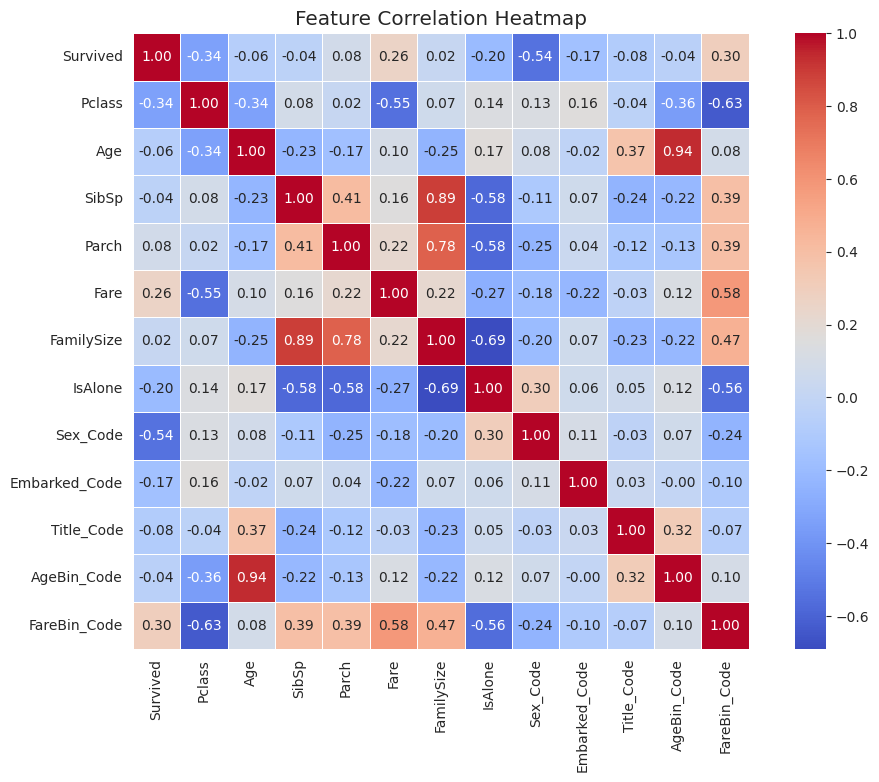

In [78]:
sns.heatmap(data1.corr(), annot=True, square=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')